In [93]:
# CORE PYTHON & DATA MANIPULATION LIBRARIES
import numpy as np                # Numerical computations, arrays, math operations
import pandas as pd               # Data handling, DataFrames, time-series structures
import os                         # OS-level utilities (path handling, directory checks, file management)
# VISUALIZATION LIBRARIES
import matplotlib.pyplot as plt   # Main plotting library
import seaborn as sns             # Statistical and enhanced visualization tools
from scipy import stats
import statsmodels.api as sm
from itertools import product

In [94]:
print("===============================")
print("HELPER FUNCTIONS")
print("===============================\n")

print("Get revision number - Returns the next free integer revision based on existing files")
def get_revision_number(base_path, base_name):
    rev = 0
    while True:
        full_path = os.path.join(base_path, base_name + "_" + str(rev) + ".csv")
        if not os.path.exists(full_path):
            return rev
        rev += 1

print("Inverse Box-Cox - Converts Box-Cox transformed values back to the original scale")
def invboxcox(y, lmbda):
    return np.exp(y) if lmbda == 0 else np.exp(np.log(lmbda * y + 1) / lmbda)

HELPER FUNCTIONS

Get revision number - Returns the next free integer revision based on existing files
Inverse Box-Cox - Converts Box-Cox transformed values back to the original scale


In [95]:
print("===============================")
print("INPUTS")
print("===============================")

raw_data_input_path = "../data/raw/raw_price_dowloaded_1h_START_10-01-2015_END_18-01-2026.csv"  # Path to raw input CSV
processed_data_output_path = "../data/processed/"  # Output folder for saved datasets/metrics
raw_data_separator = ";"    # CSV separator for the raw file
test_size = 0.05     # Fraction of data reserved for test split
accepted_alpha = 0.05 # ADF alpha threshold to accept stationarity
figHeight_unit = 8          # Base figure height
figWidth_unit = 12          # Base figure width
resample_key = "1-Hour"     # Resample key "1-Hour", "4-Hour", "Daily", "Monthly", "Quarter", "Yearly"

print(f"raw_data_input_path: {raw_data_input_path}")
print(f"processed_data_output_path: {processed_data_output_path}")
print(f"raw_data_separator: {raw_data_separator}")
print(f"test_size: {test_size}")
print(f"accepted_alpha: {accepted_alpha}")
print(f"figHeight_unit: {figHeight_unit}")
print(f"figWidth_unit: {figWidth_unit}")
print(f"resample_key: {resample_key}")

INPUTS
raw_data_input_path: ../data/raw/raw_price_dowloaded_1h_START_10-01-2015_END_18-01-2026.csv
processed_data_output_path: ../data/processed/
raw_data_separator: ;
test_size: 0.05
accepted_alpha: 0.05
figHeight_unit: 8
figWidth_unit: 12
resample_key: 1-Hour


STEP 1) EXPLORE DATAFRAME AND PLOT DIFERENT RESAMPLES


,time,open,max,min,close
0,10/01/2015 0:00,293.89,295.00,289.10,289.22
1,10/01/2015 1:00,289.20,291.49,286.00,289.18
2,10/01/2015 2:00,289.18,289.18,286.01,287.00
3,10/01/2015 3:00,286.66,288.38,286.65,288.38
4,10/01/2015 4:00,288.38,292.88,288.04,290.24


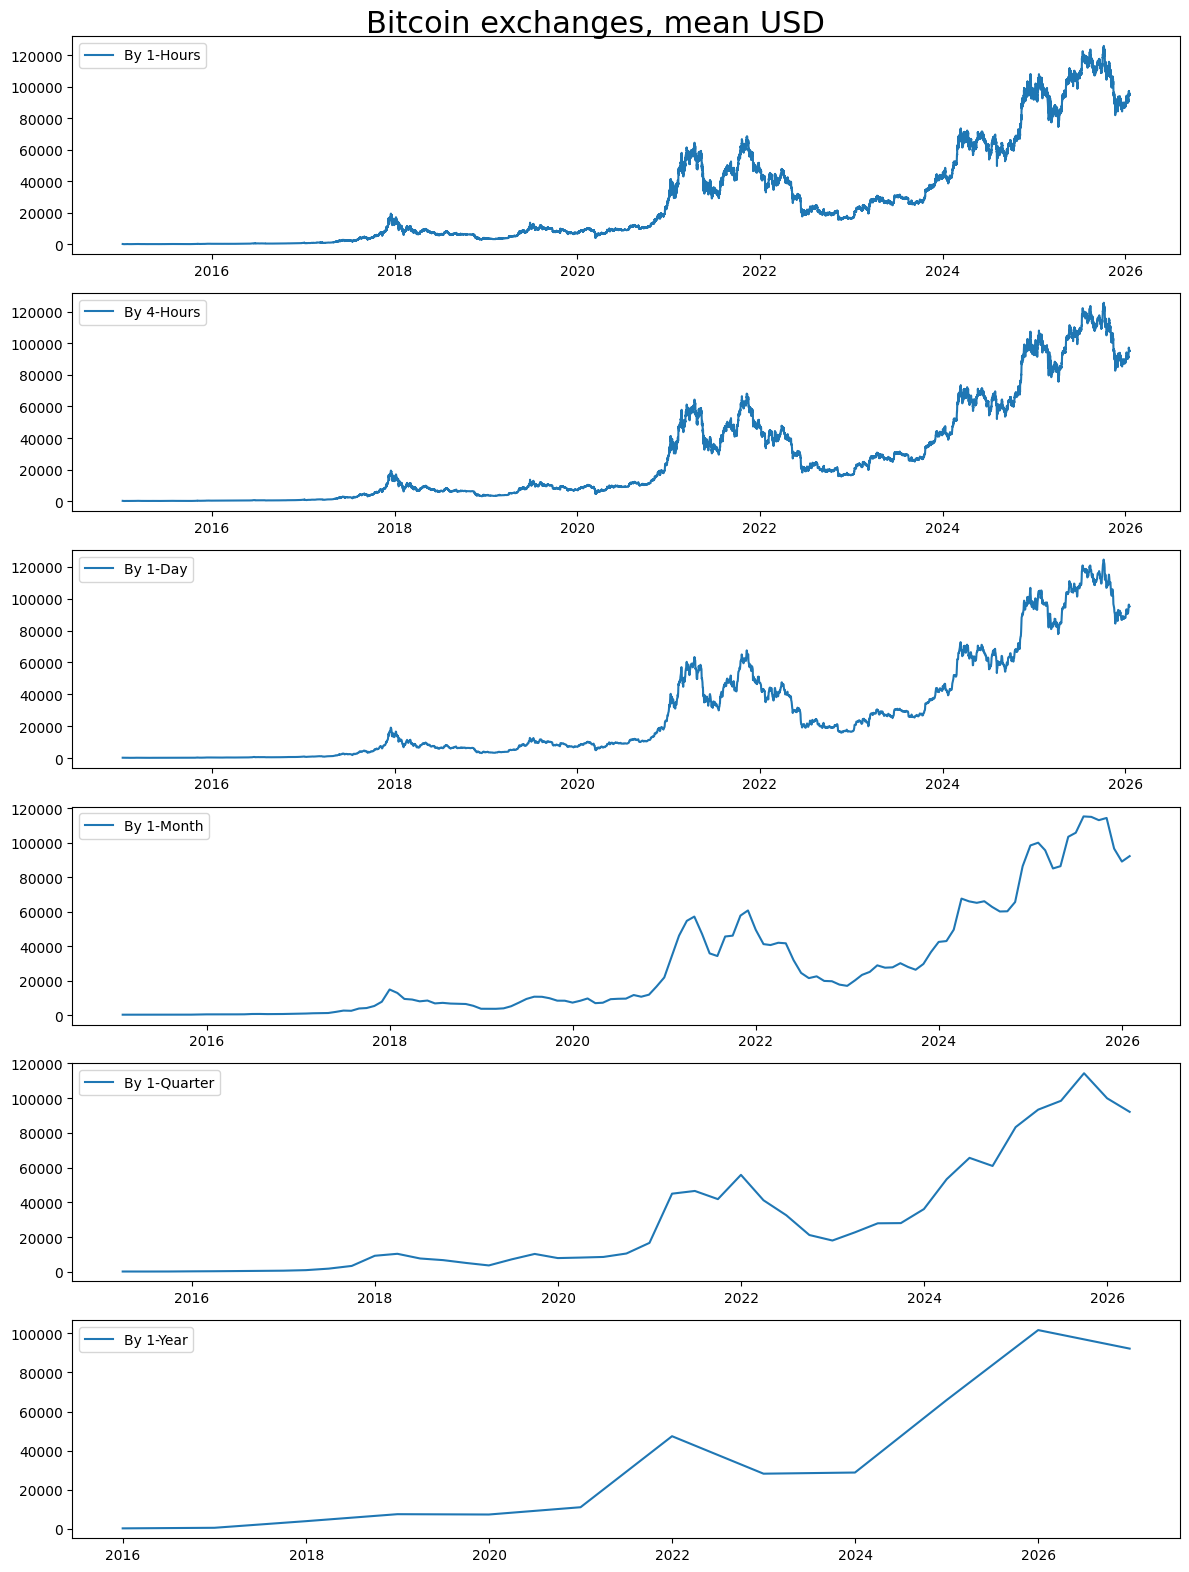

In [96]:
print("===============================")
print("STEP 1) EXPLORE DATAFRAME AND PLOT DIFERENT RESAMPLES")
print("===============================")

df = pd.read_csv(raw_data_input_path, sep=raw_data_separator)
display(df.head())

# Convert time and set index (hourly data)
df = df.copy()
df["time"] = pd.to_datetime(df["time"], dayfirst=True)
df = df.sort_values("time").set_index("time")

# Resamples
df_hour = df.resample("h").mean(numeric_only=True)
df_4h = df.resample("4h").mean(numeric_only=True)
df_day = df.resample("D").mean(numeric_only=True)
df_month = df.resample("ME").mean(numeric_only=True)
df_q = df.resample("QE-DEC").mean(numeric_only=True)
df_year = df.resample("YE-DEC").mean(numeric_only=True)

# Plots
fig, axes = plt.subplots(6, 1, figsize=(figWidth_unit, figHeight_unit*2))
fig.suptitle("Bitcoin exchanges, mean USD", fontsize=22)

axes[0].plot(df_hour["close"], "-", label="By 1-Hours")
axes[0].legend()

axes[1].plot(df_4h["close"], "-", label="By 4-Hours")
axes[1].legend()

axes[2].plot(df_day["close"], "-", label="By 1-Day")
axes[2].legend()

axes[3].plot(df_month["close"], "-", label="By 1-Month")
axes[3].legend()

axes[4].plot(df_q["close"], "-", label="By 1-Quarter")
axes[4].legend()

axes[5].plot(df_year["close"], "-", label="By 1-Year")
axes[5].legend()

plt.tight_layout()
plt.show()

STEP 2) STATIONARY CHECK AND STL-DECOMPOSITION


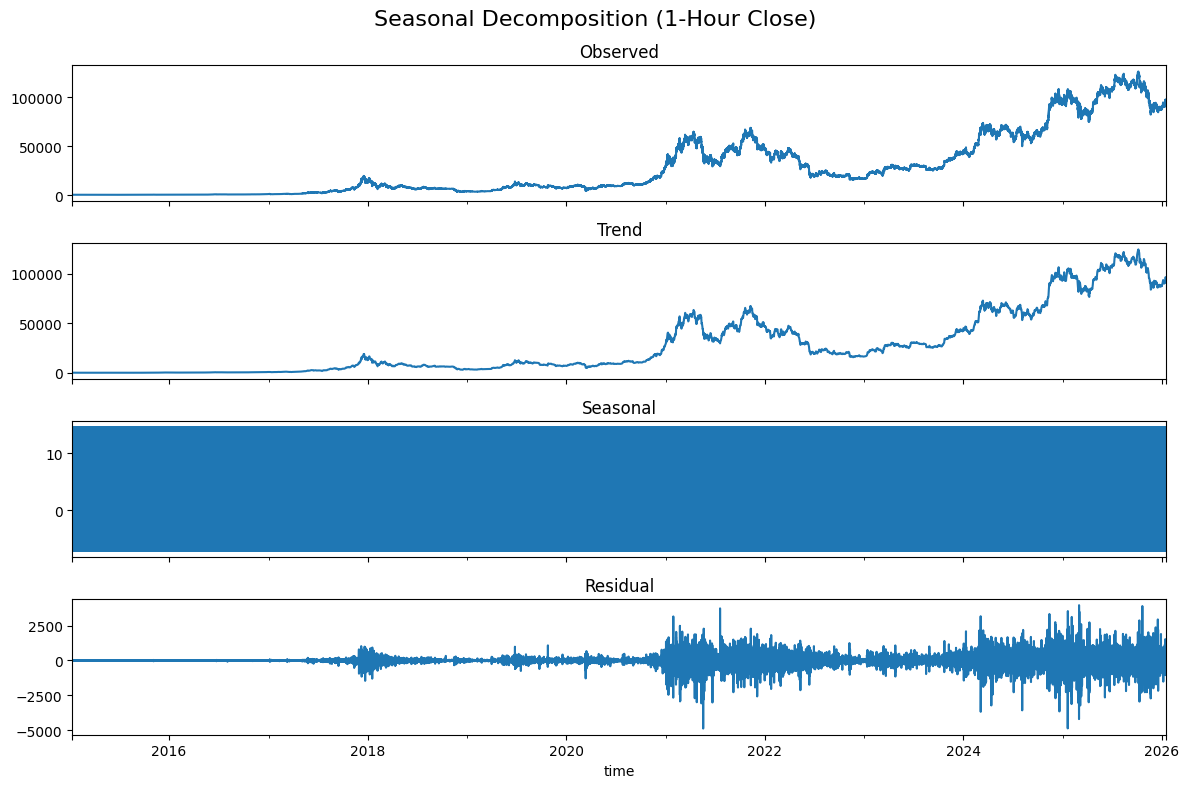

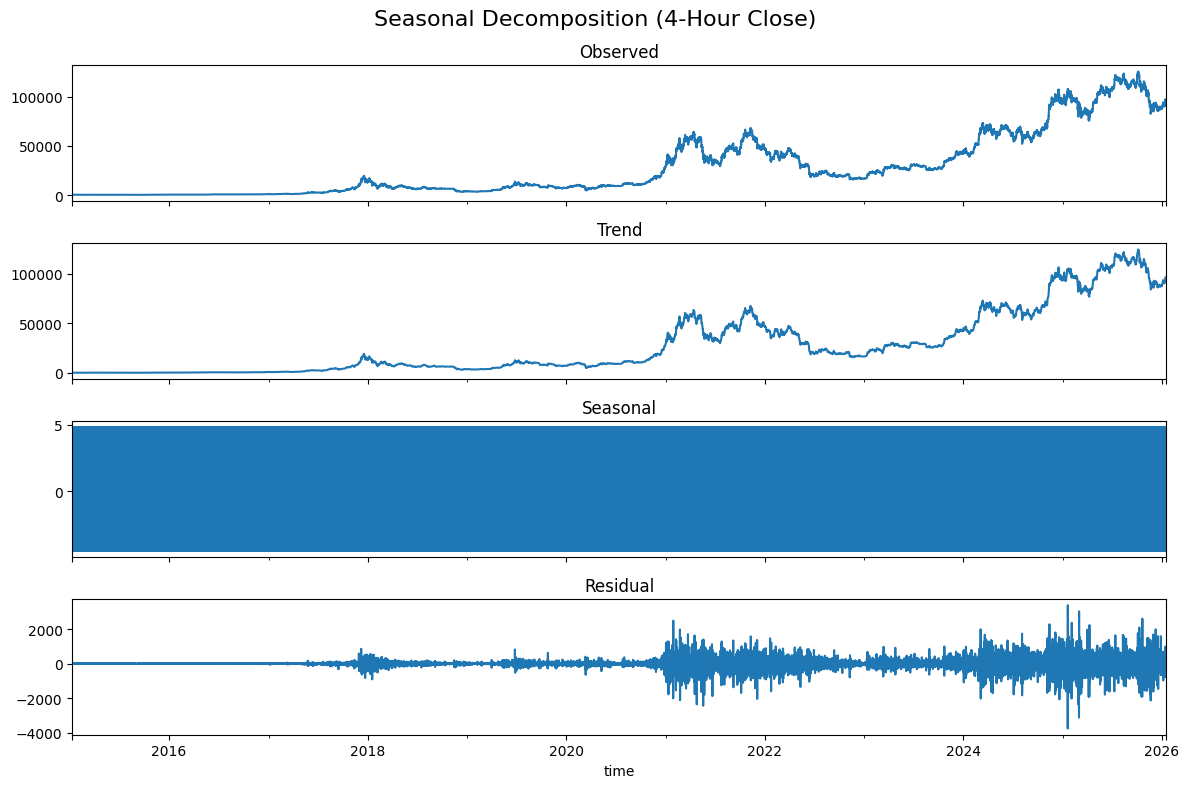

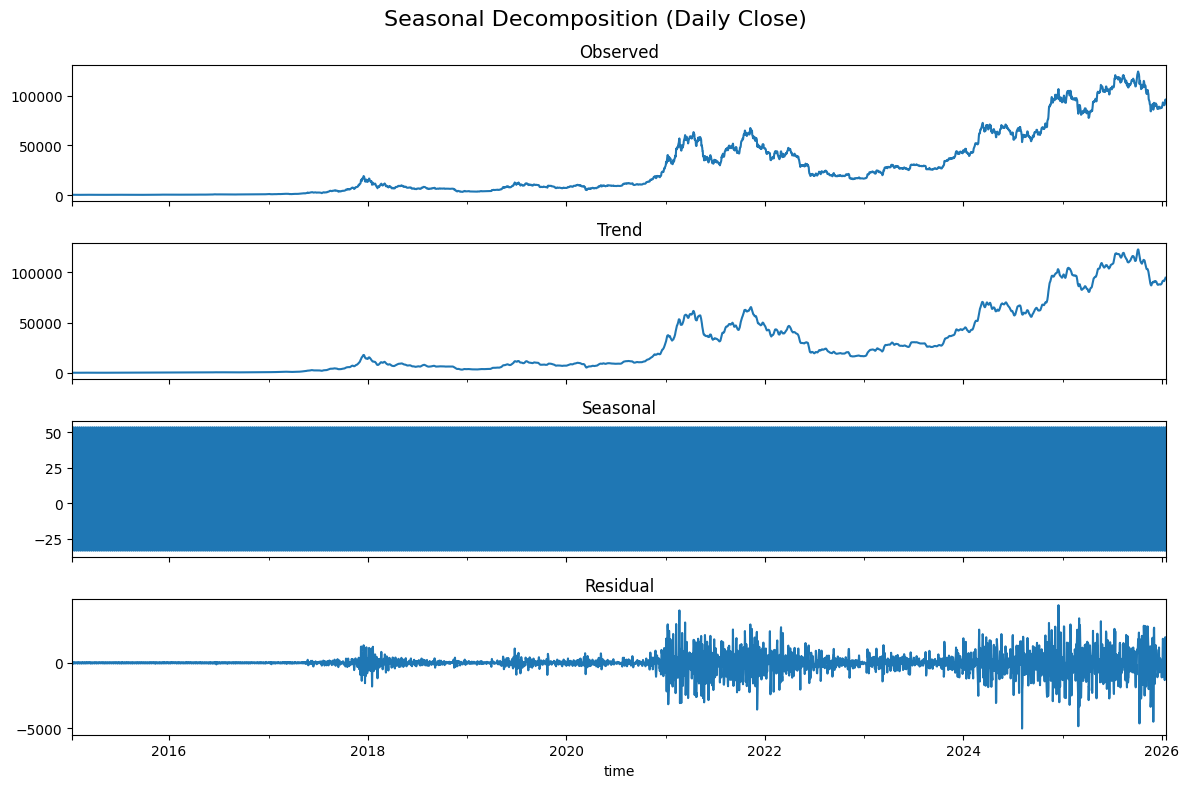

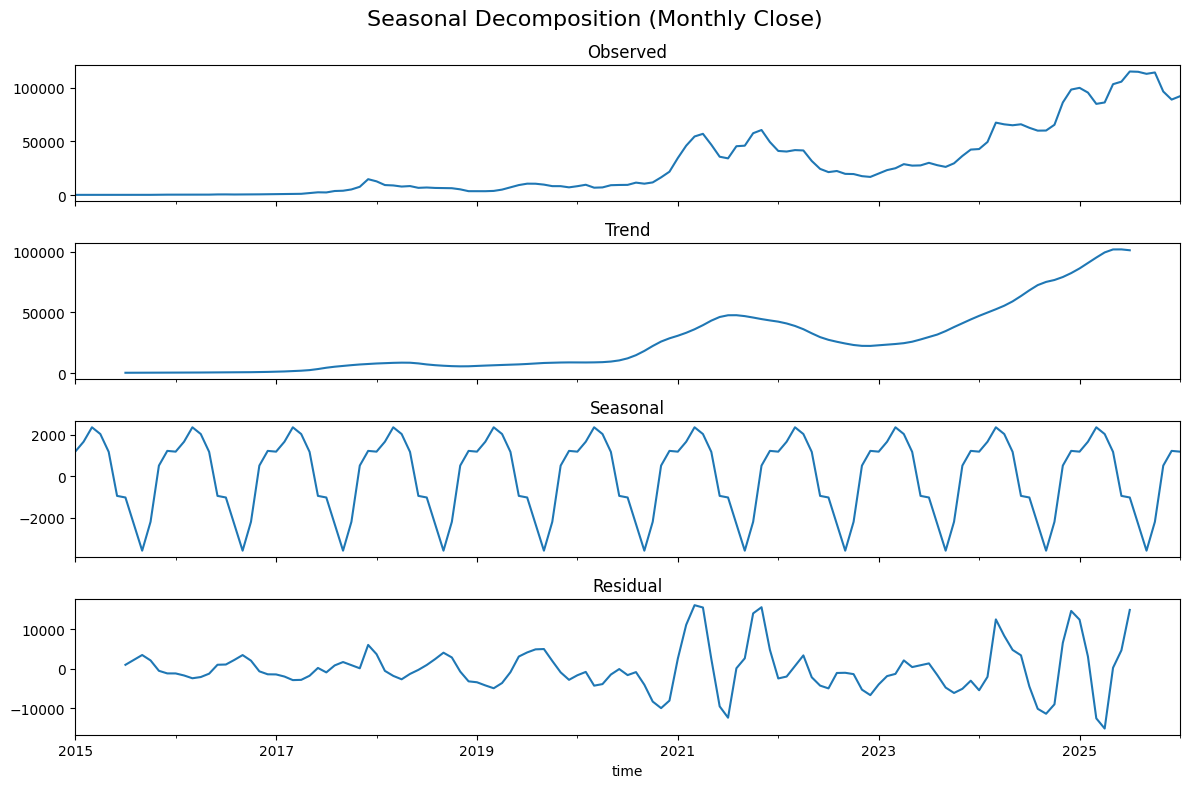

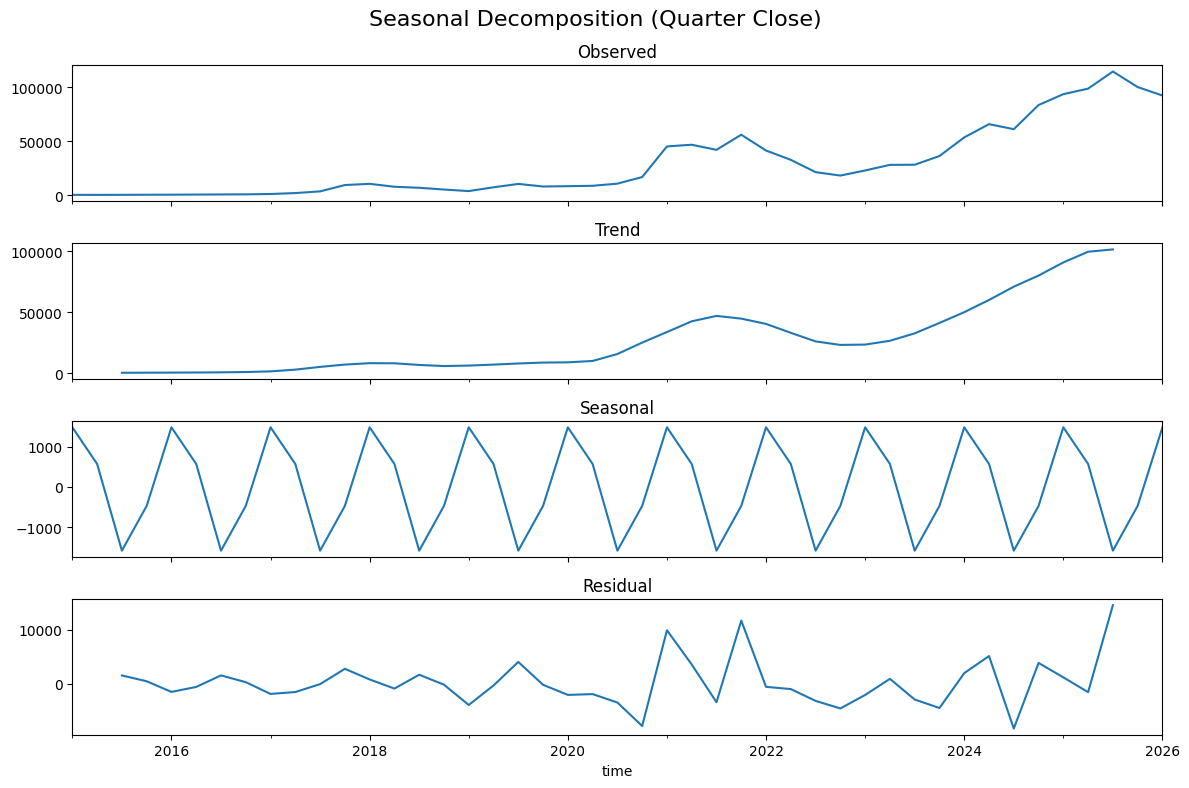

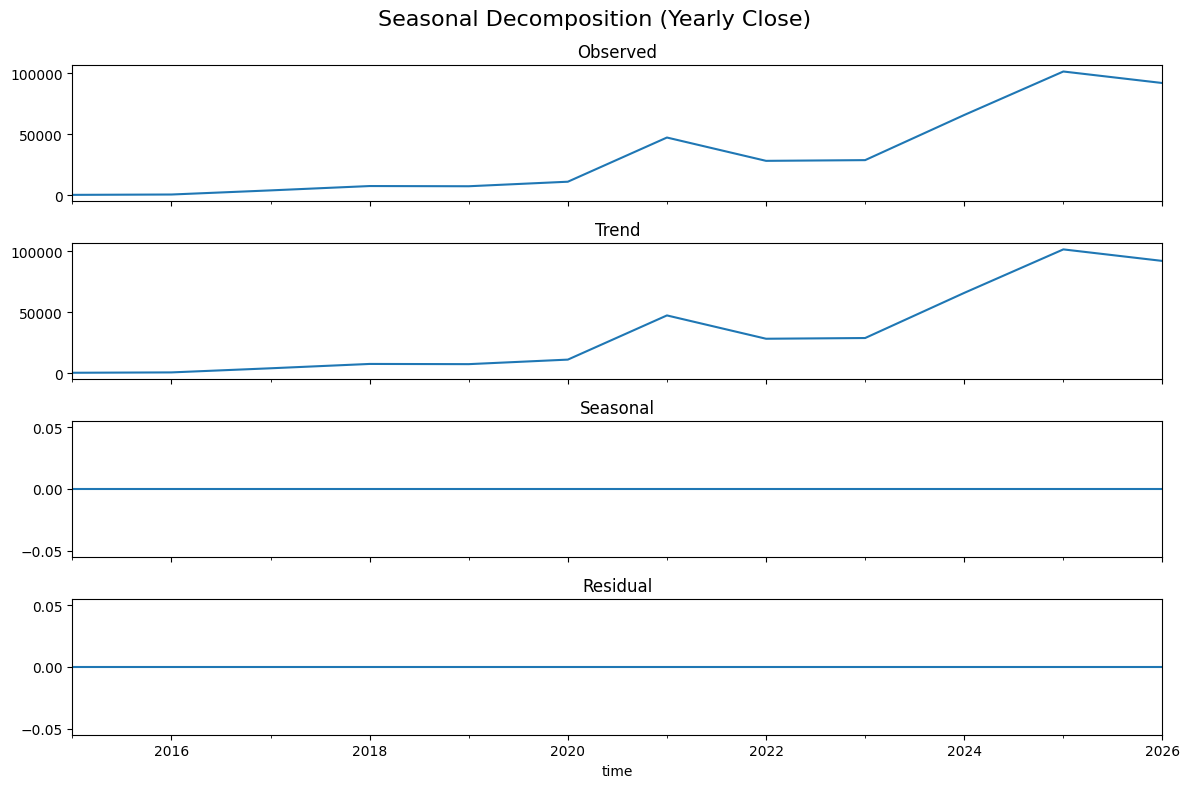

,resample,p_value,stationary
0,1-Hour,0.932762,No
1,4-Hour,0.940172,No
2,Daily,0.886656,No
3,Monthly,0.775203,No
4,Quarter,0.961540,No
5,Yearly,0.997617,No


In [97]:
print("===============================")
print("STEP 2) STATIONARY CHECK AND STL-DECOMPOSITION")
print("===============================")

# Map each resample to a label and a seasonal period
series_specs = {
    "1-Hour":  {"df": df_hour,  "period": 24},   # daily seasonality
    "4-Hour":  {"df": df_4h,    "period": 6},    # 24h / 4h = 6
    "Daily":   {"df": df_day,   "period": 7},    # weekly seasonality
    "Monthly": {"df": df_month, "period": 12},   # yearly seasonality
    "Quarter": {"df": df_q,     "period": 4},    # yearly seasonality
    "Yearly":  {"df": df_year,  "period": 1}     # no real seasonality
}

results = []
for label, spec in series_specs.items():
    series = spec["df"]["close"].dropna()
    period = spec["period"]

    # Skip if too short for decomposition
    if len(series) < period * 2:
        results.append({
            "resample": label,
            "p_value": None,
            "stationary": "Not enough data"
        })
        continue
    # Seasonal decomposition
    fig, axes = plt.subplots(4, 1, figsize=(figWidth_unit, figHeight_unit), sharex=True)
    decomp = sm.tsa.seasonal_decompose(series, model="additive", period=period)
    decomp.observed.plot(ax=axes[0], title="Observed")
    decomp.trend.plot(ax=axes[1], title="Trend")
    decomp.seasonal.plot(ax=axes[2], title="Seasonal")
    decomp.resid.plot(ax=axes[3], title="Residual")
    fig.suptitle(f"Seasonal Decomposition ({label} Close)", fontsize=16)
    plt.tight_layout()
    plt.show()
    # ADF test
    p_value = sm.tsa.stattools.adfuller(series)[1]
    is_stationary = "Yes" if p_value < accepted_alpha else "No"
    results.append({
        "resample": label,
        "p_value": p_value,
        "stationary": is_stationary
    })
# Summary table
stationarity_table = pd.DataFrame(results)
stationarity_table

In [98]:
print("===============================")
print("STEP 3) BOX-COX SUITABILITY SUMMARY")
print("===============================")
# Box-Cox transforms the series to stabilize variance and make it closer to normal,
# which can help linear time-series models fit better.
results = []
for label, spec in series_specs.items():
    # Extract series
    series = spec["df"]["close"].dropna().astype(float)
    # Box-Cox requires strictly positive values
    if (series <= 0).any():
        results.append({
            "resample": label,
            "lambda": None,
            "adf_pvalue": None,
            "stationary": "Not tested",
            "boxcox_recommendation": "Not applicable",
            "note": "Non-positive values"
        })
        continue
    # Box-Cox lambda
    boxcox_vals, lmbda = stats.boxcox(series)
    # ADF on original series
    p_value = sm.tsa.stattools.adfuller(series)[1]
    is_stationary = "Yes" if p_value < accepted_alpha else "No"
    # Simple heuristic: if lambda far from 1, Box-Cox may help
    if abs(lmbda - 1) < 0.2:
        rec = "Probably not needed"
    elif abs(lmbda) < 0.2:
        rec = "Log/Box-Cox likely helpful"
    else:
        rec = "May help (variance stabilization)"
    results.append({
        "resample": label,
        "lambda": round(lmbda, 3),
        "adf_pvalue": p_value,
        "stationary": is_stationary,
        "boxcox_recommendation": rec,
        "note": "OK"
    })
boxcox_table = pd.DataFrame(results)
boxcox_table

STEP 3) BOX-COX SUITABILITY SUMMARY


,resample,lambda,adf_pvalue,stationary,boxcox_recommendation,note
0,1-Hour,0.200,0.932762,No,May help (variance stabilization),OK
1,4-Hour,0.200,0.940172,No,May help (variance stabilization),OK
2,Daily,0.200,0.886656,No,May help (variance stabilization),OK
3,Monthly,0.202,0.775203,No,May help (variance stabilization),OK
4,Quarter,0.210,0.961540,No,May help (variance stabilization),OK
5,Yearly,0.240,0.997617,No,May help (variance stabilization),OK


In [99]:
print("===============================")
print("STEP 4) SEASONAL DIFFERENCING STATIONARY CHECK")
print("===============================")
# This checks if removing the seasonal component alone is enough to make the series stationary.
results = []
for label, spec in series_specs.items():
    # Extract series and seasonal period for this resample
    series = spec["df"]["close"].dropna().astype(float)
    period = spec["period"]
    # Seasonal differencing
    series_diff = series.diff(period)
    # ADF test on seasonally differenced series
    p_value = sm.tsa.stattools.adfuller(series_diff.dropna())[1]
    is_stationary = "Yes" if p_value < accepted_alpha else "No"
    results.append({
        "resample": label,
        "adf_pvalue_diff": p_value,
        "stationary_diff": is_stationary
    })
diff_table = pd.DataFrame(results)
diff_table

STEP 4) SEASONAL DIFFERENCING STATIONARY CHECK


,resample,adf_pvalue_diff,stationary_diff
0,1-Hour,0.000000e+00,Yes
1,4-Hour,0.000000e+00,Yes
2,Daily,3.135478e-14,Yes
3,Monthly,2.241654e-02,Yes
4,Quarter,9.990413e-05,Yes
5,Yearly,7.974385e-03,Yes


STEP 5) SEASONAL + REGULAR DIFFERENCING STATIONARTY CHECK


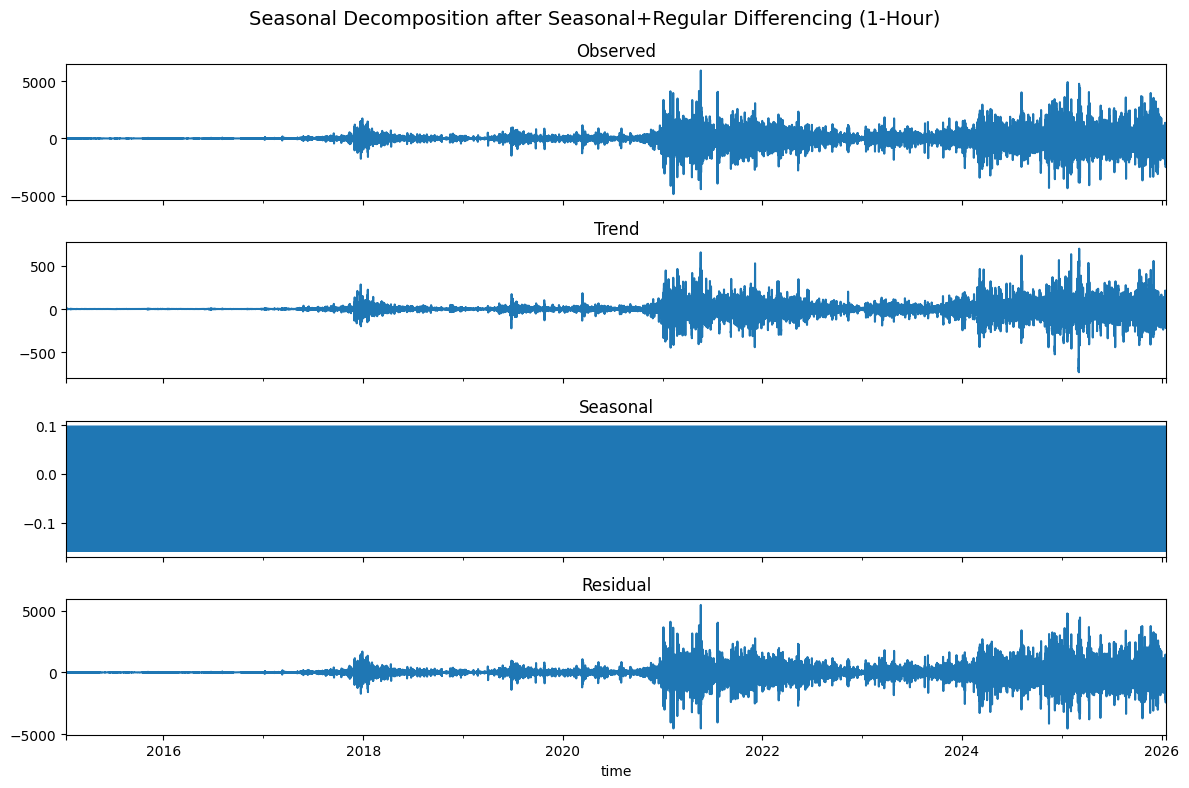

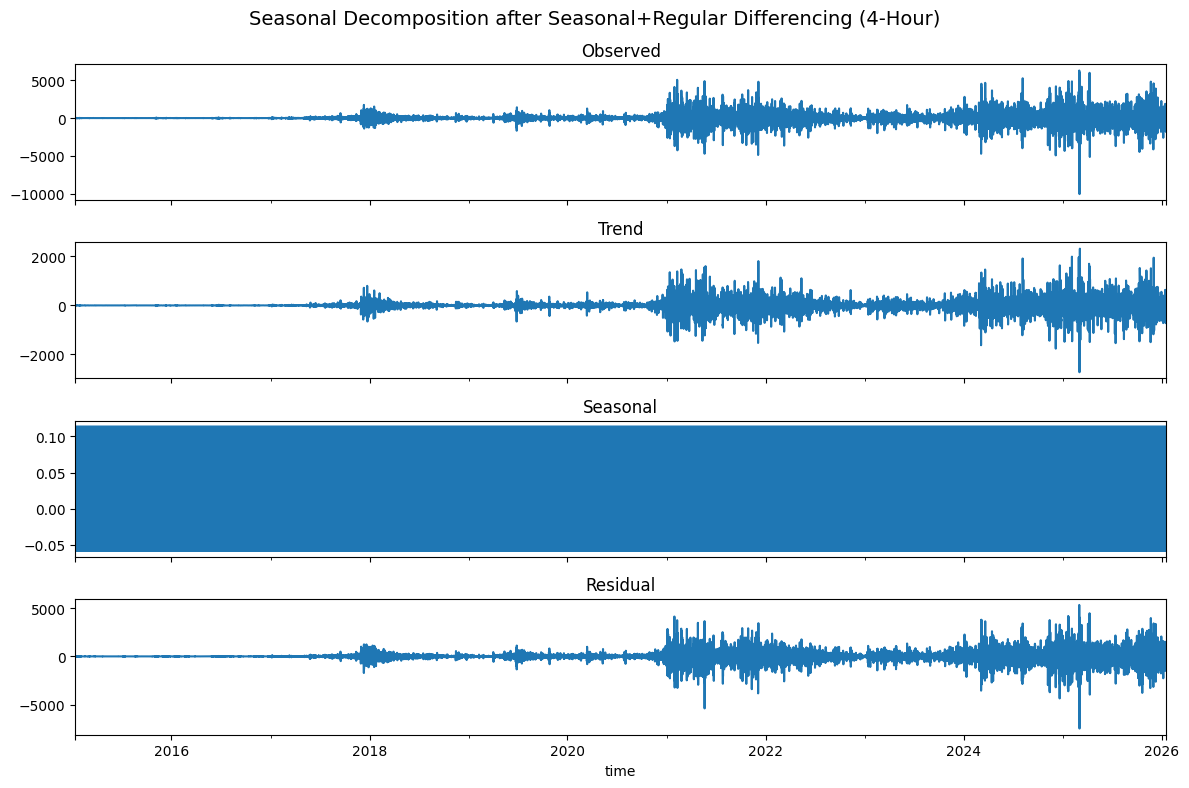

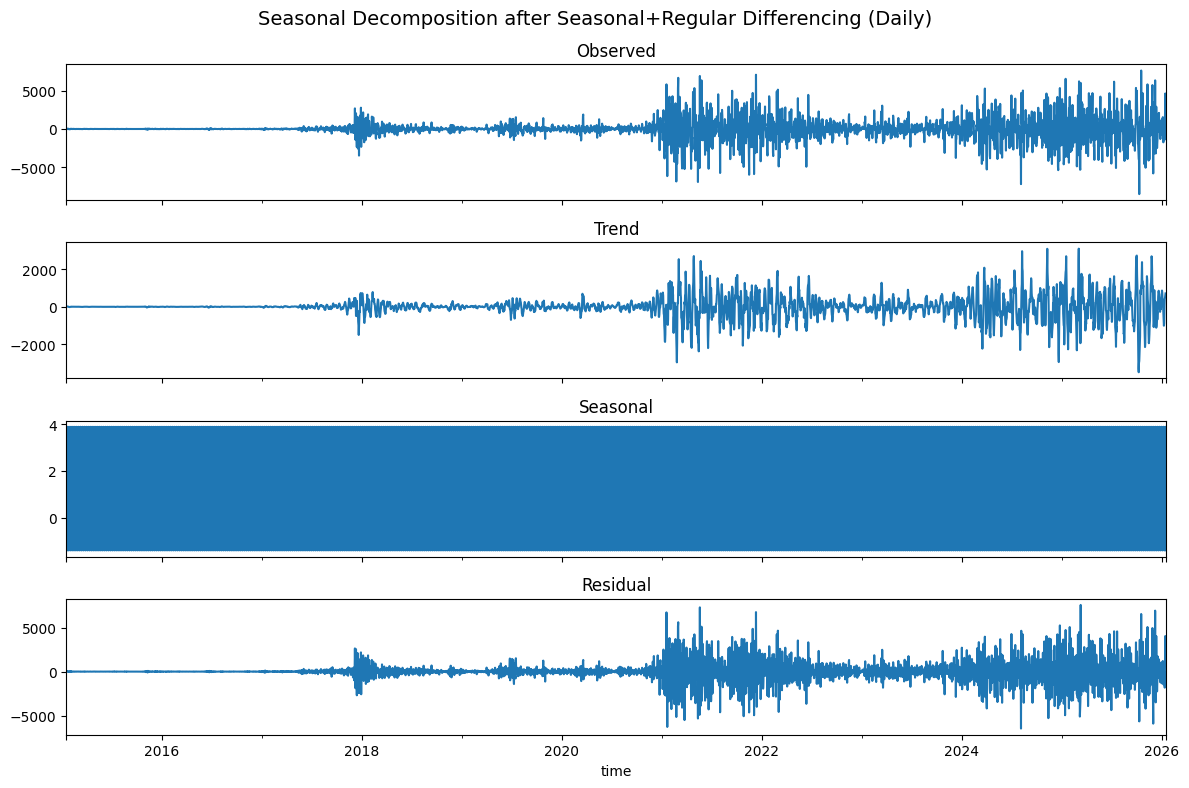

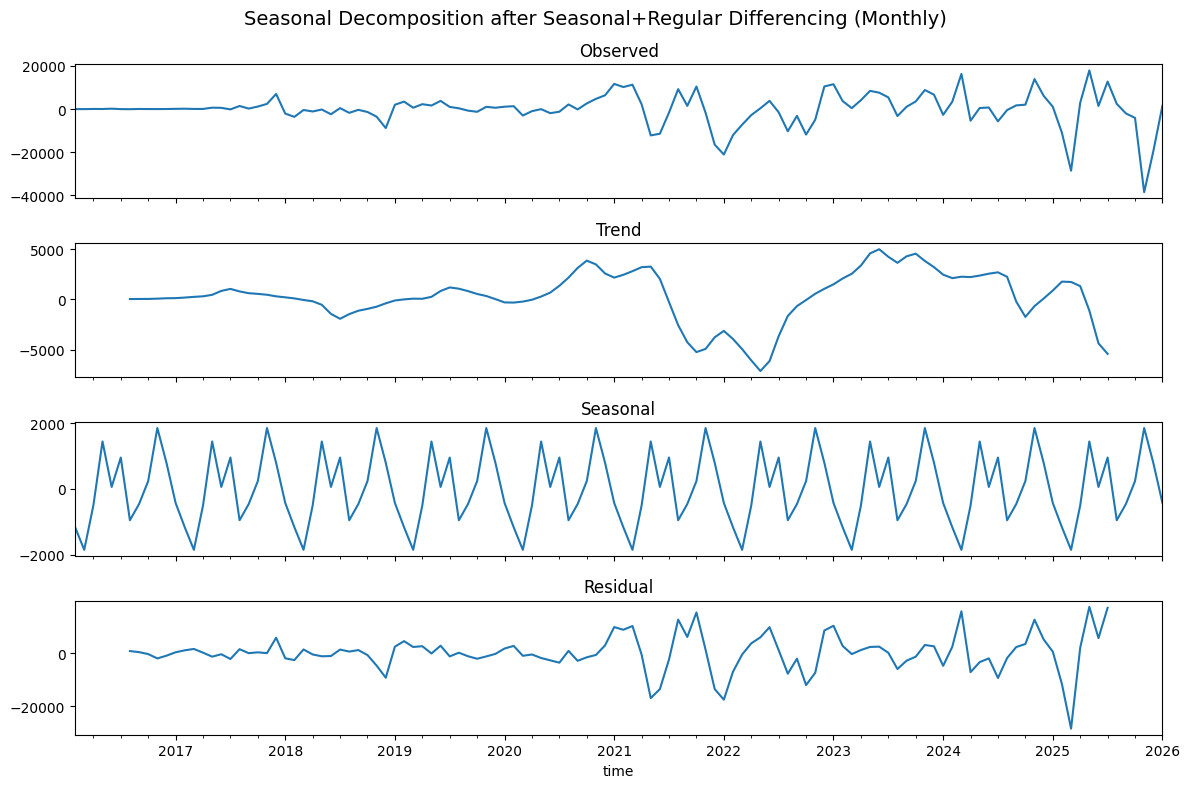

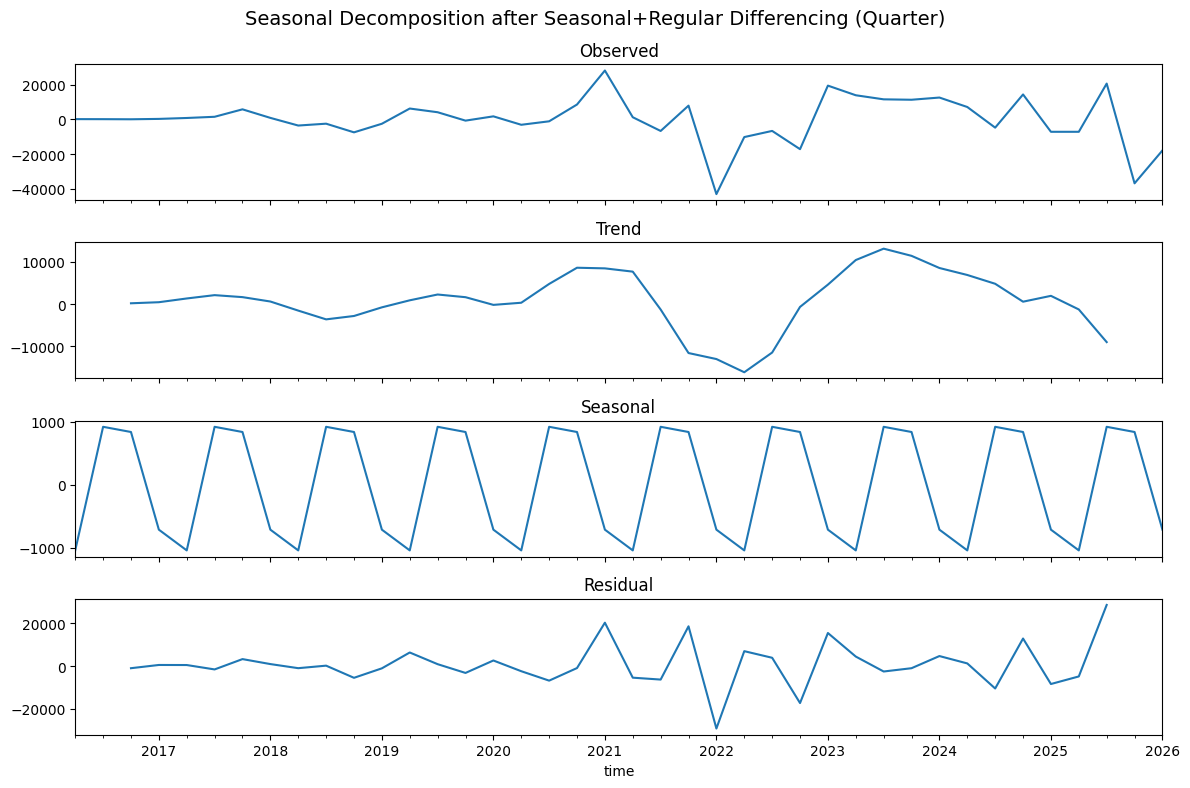

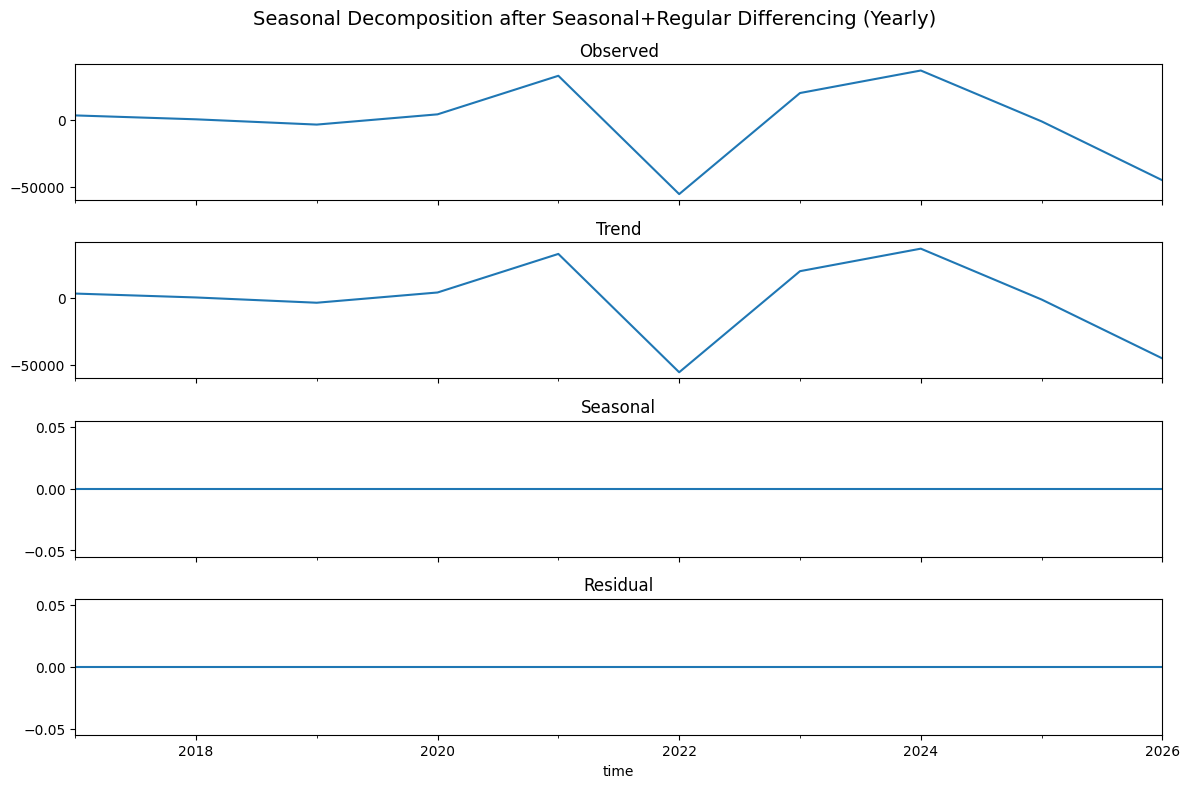

,resample,adf_pvalue_diff2,stationary_diff2
0,1-Hour,0.000000e+00,Yes
1,4-Hour,0.000000e+00,Yes
2,Daily,2.975298e-29,Yes
3,Monthly,6.706913e-02,No
4,Quarter,8.523932e-03,Yes
5,Yearly,3.444488e-02,Yes


In [100]:
print("===============================")
print("STEP 5) SEASONAL + REGULAR DIFFERENCING STATIONARTY CHECK")
print("===============================")
# This checks if an additional regular differencing step is needed after seasonal differencing.
results = []
for label, spec in series_specs.items():
    # Extract series and seasonal period for this resample
    series = spec["df"]["close"].dropna().astype(float)
    period = spec["period"]
    # Seasonal differencing (remove seasonal pattern)
    series_seasonal_diff = series.diff(period)
    # Regular differencing (remove remaining trend)
    series_diff2 = series_seasonal_diff.diff(1)
    # STL/seasonal decomposition on the differenced series
    fig, axes = plt.subplots(4, 1, figsize=(figWidth_unit, figHeight_unit), sharex=True)
    decomp = sm.tsa.seasonal_decompose(series_diff2.dropna(), model="additive", period=period)

    decomp.observed.plot(ax=axes[0], title="Observed")
    decomp.trend.plot(ax=axes[1], title="Trend")
    decomp.seasonal.plot(ax=axes[2], title="Seasonal")
    decomp.resid.plot(ax=axes[3], title="Residual")

    fig.suptitle(f"Seasonal Decomposition after Seasonal+Regular Differencing ({label})", fontsize=14)
    plt.tight_layout()
    plt.show()

    # ADF test on the differenced series
    p_value = sm.tsa.stattools.adfuller(series_diff2.dropna())[1]
    is_stationary = "Yes" if p_value < accepted_alpha else "No"

    results.append({
        "resample": label,
        "adf_pvalue_diff2": p_value,
        "stationary_diff2": is_stationary
    })
diff2_table = pd.DataFrame(results)
diff2_table

STEP 6) CONDITIONAL DIFFERENCING + ACF/PACF PARAMETER INIT


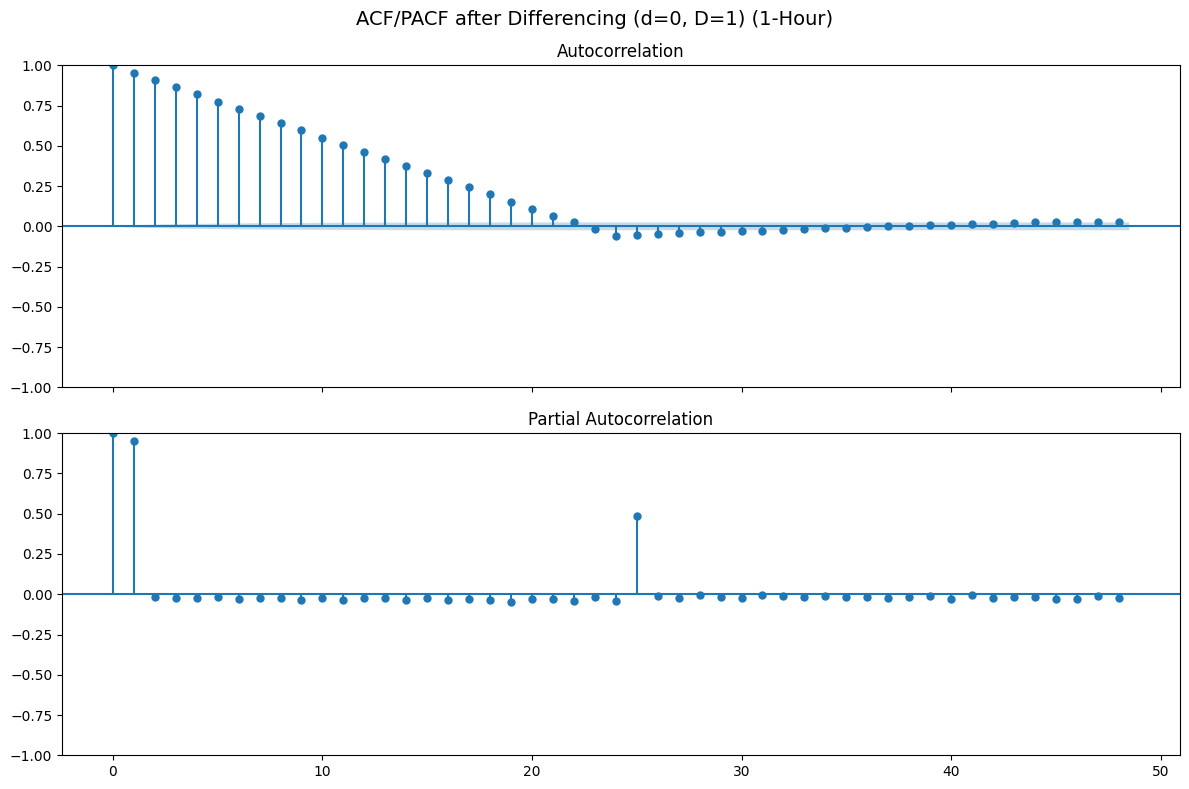

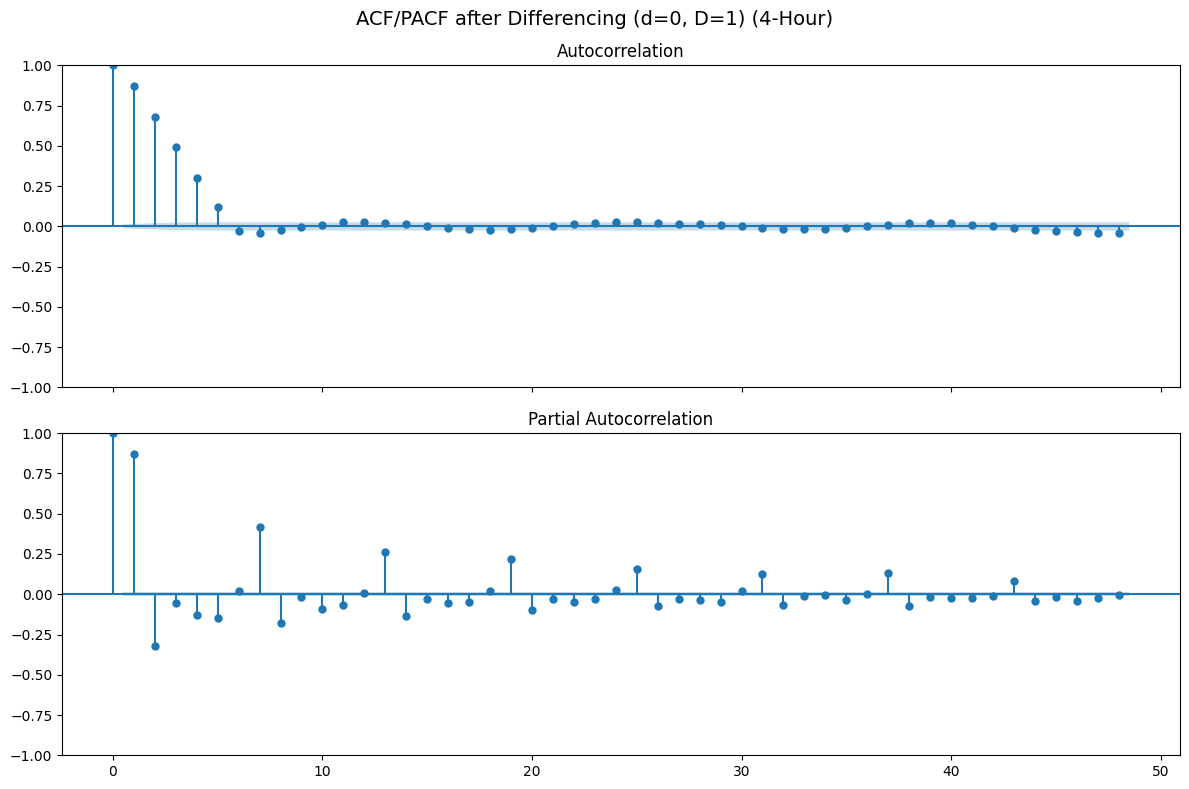

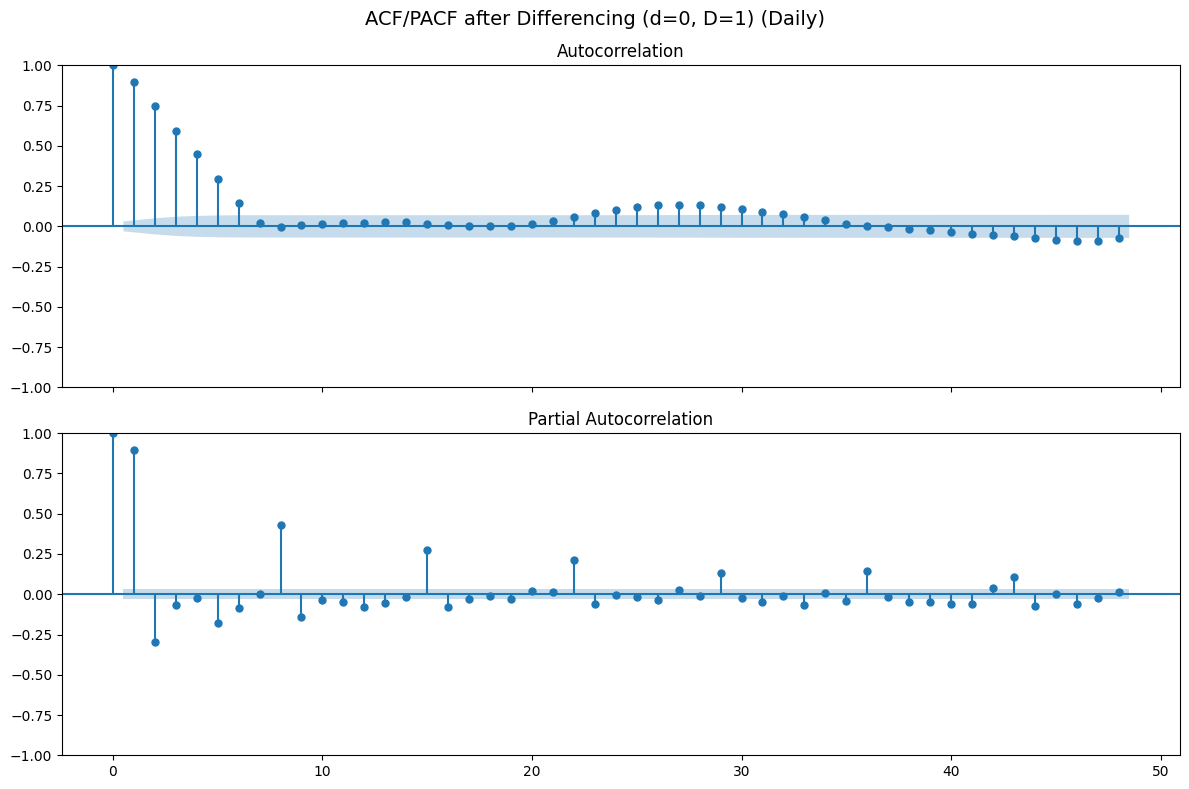

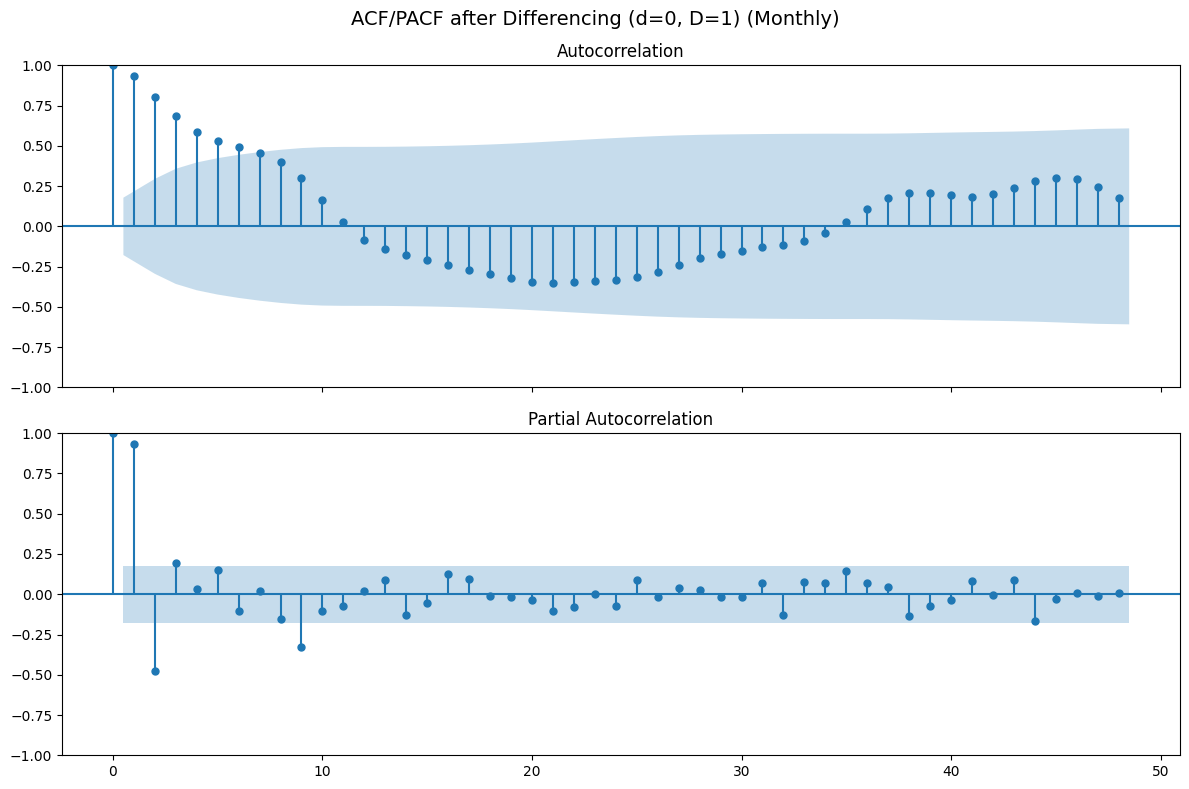

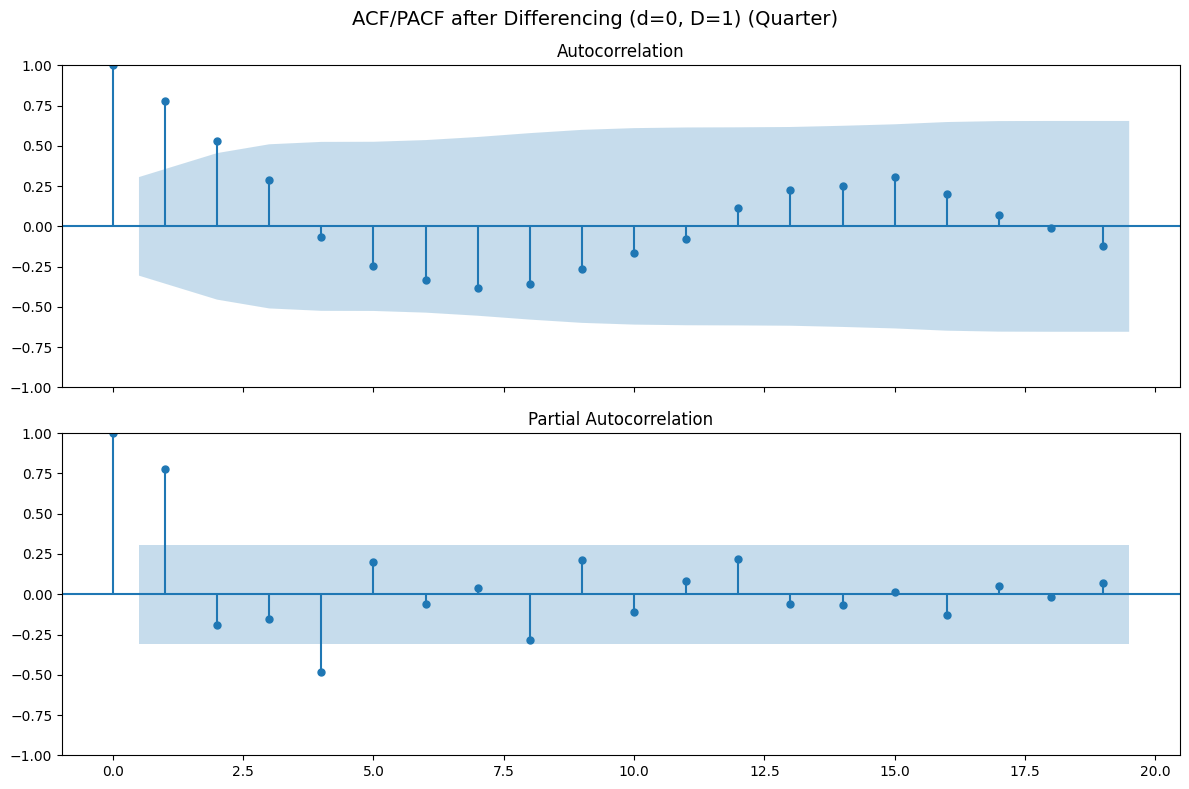

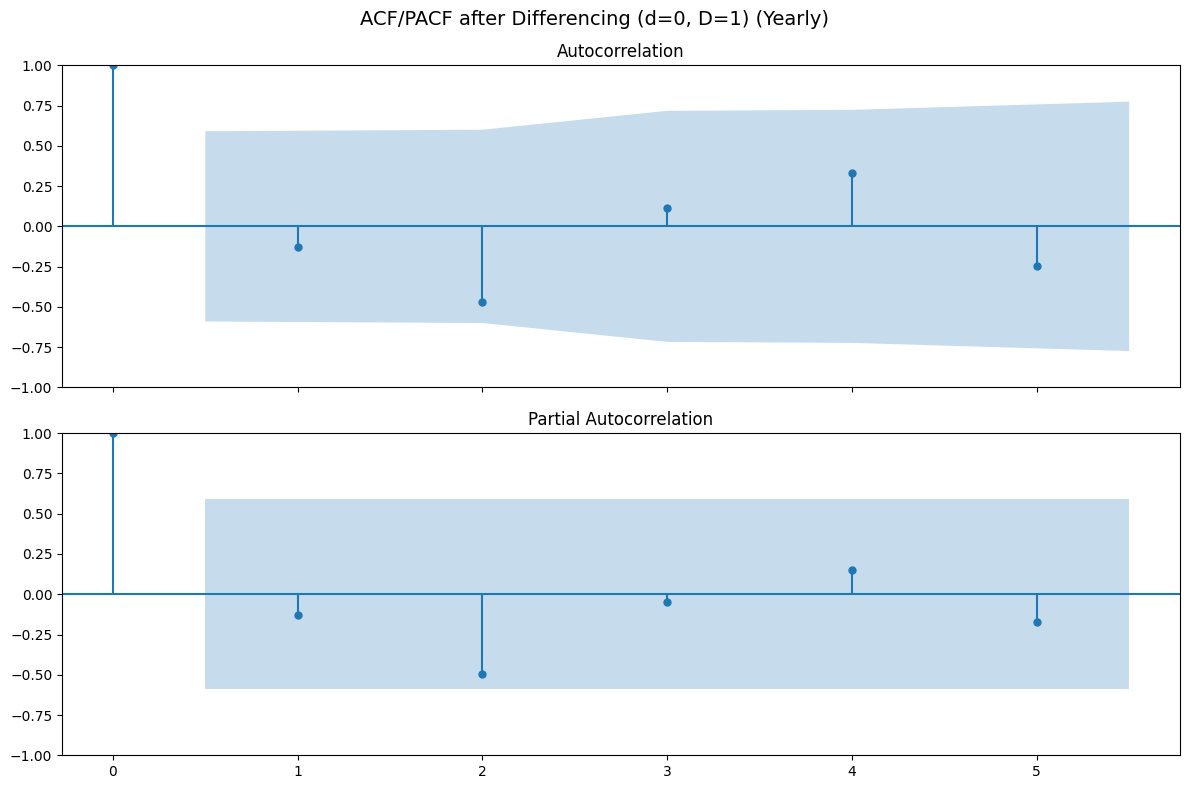

,resample,p,d,q,P,D,Q,m
0,1-Hour,(0-2),(0-0),(0-2),(0-2),(1-1),(0-2),24
1,4-Hour,(0-2),(0-0),(0-2),(0-2),(1-1),(0-2),6
2,Daily,(0-2),(0-0),(0-2),(0-2),(1-1),(0-2),7
3,Monthly,(0-2),(0-0),(0-2),(0-2),(1-1),(0-2),12
4,Quarter,(0-2),(0-0),(0-2),(0-2),(1-1),(0-2),4
5,Yearly,(0-2),(0-0),(0-2),(0-2),(1-1),(0-2),1


In [104]:
print("===============================")
print("STEP 6) CONDITIONAL DIFFERENCING + ACF/PACF PARAMETER INIT")
print("===============================")
# This chooses d and D based on stationarity checks, applies the right differencing,
# and then estimates initial p/q ranges from ACF/PACF for each resample.
# Build quick lookup for stationarity flags
diff_map = dict(zip(diff_table["resample"], diff_table["stationary_diff"]))
diff2_map = dict(zip(diff2_table["resample"], diff2_table["stationary_diff2"]))

initial_params = []
table_rows = []

for label, spec in series_specs.items():
    series = spec["df"]["close"].dropna().astype(float)
    m = spec["period"]

    # Decide D and d based on stationarity checks
    if diff_map.get(label) == "Yes":
        D, d = 1, 0
    elif diff2_map.get(label) == "Yes":
        D, d = 1, 1
    else:
        D, d = 1, 1  # fallback if still non-stationary

    # Apply differencing based on chosen D/d
    series_diff = series.copy()
    if D == 1:
        series_diff = series_diff.diff(m)
    if d == 1:
        series_diff = series_diff.diff(1)
    series_diff = series_diff.dropna()

    # Safe max lags
    max_lags = min(48, max(5, len(series_diff)//2 - 1))

    # Plot ACF/PACF
    fig, axes = plt.subplots(2, 1, figsize=(figWidth_unit, figHeight_unit), sharex=True)
    sm.graphics.tsa.plot_acf(series_diff.values.squeeze(), lags=max_lags, ax=axes[0])
    sm.graphics.tsa.plot_pacf(series_diff.values.squeeze(), lags=max_lags, ax=axes[1])
    fig.suptitle(f"ACF/PACF after Differencing (d={d}, D={D}) ({label})", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Significant lags for initial p and q
    acf_vals, acf_ci = sm.tsa.stattools.acf(series_diff, nlags=max_lags, alpha=0.05)
    pacf_vals, pacf_ci = sm.tsa.stattools.pacf(series_diff, nlags=max_lags, alpha=0.05, method="ywmle")

    q_candidates = [i for i in range(1, len(acf_vals)) if acf_vals[i] < acf_ci[i, 0] or acf_vals[i] > acf_ci[i, 1]]
    p_candidates = [i for i in range(1, len(pacf_vals)) if pacf_vals[i] < pacf_ci[i, 0] or pacf_vals[i] > pacf_ci[i, 1]]

    p_init = p_candidates[0] if p_candidates else 0
    q_init = q_candidates[0] if q_candidates else 0

    # Ranges to use later
    p_range = range(0, min(p_init + 3, 5))
    q_range = range(0, min(q_init + 3, 5))
    P_range = range(0, 3)
    Q_range = range(0, 3)

    # Store ranges for later use
    initial_params.append({
        "resample": label,
        "p_range": p_range,
        "d_range": range(d, d + 1),
        "q_range": q_range,
        "P_range": P_range,
        "D_range": range(D, D + 1),
        "Q_range": Q_range,
        "m": m
    })

    # Clean table view
    table_rows.append({
        "resample": label,
        "p": f"(0-{p_range.stop-1})",
        "d": f"({d}-{d})",
        "q": f"(0-{q_range.stop-1})",
        "P": f"(0-{P_range.stop-1})",
        "D": f"({D}-{D})",
        "Q": f"(0-{Q_range.stop-1})",
        "m": m
    })

initial_params_table = pd.DataFrame(table_rows)
initial_params_table


In [102]:
print("===============================")
print("STEP 7) RESAMPLE SPLIT + SAVE")
print("===============================")
# This selects the resample, splits the series by time, and saves train/test with a suffix.
if resample_key not in series_specs:
    raise ValueError(f"Unknown resample_key: {resample_key}")

df_resample = series_specs[resample_key]["df"]
timeseries = df_resample["close"].dropna().astype(float)

# Split
split_idx = int(len(timeseries) * (1-test_size))
timeseries_train = timeseries.iloc[:split_idx]
timeseries_test = timeseries.iloc[split_idx:]
print(f"Train size: {timeseries_train.shape}")
print(f"Test size: {timeseries_test.shape}")

# Save with suffix
suffix = resample_key.lower().replace("-", "").replace(" ", "_")
rev_number = get_revision_number(processed_data_output_path, f"timeseries_train_{suffix}")
output_path_train = processed_data_output_path + f"timeseries_train_{suffix}_{rev_number}.csv"
output_path_test = processed_data_output_path + f"timeseries_test_{suffix}_{rev_number}.csv"
timeseries_train.to_csv(output_path_train, index=True)
print(f"timeseries_train saved in {processed_data_output_path} with revision number: {rev_number}")
timeseries_test.to_csv(output_path_test, index=True)
print(f"timeseries_test saved in {processed_data_output_path} with revision number: {rev_number}")

STEP 7) RESAMPLE SPLIT + SAVE
Train size: (91793,)
Test size: (4832,)
timeseries_train saved in ../data/processed/ with revision number: 0
timeseries_test saved in ../data/processed/ with revision number: 0


In [103]:
# -------------------------------
# STEP 8) SARIMAX (RESAMPLE SELECTED)
# -------------------------------
# Use train series
series_train = timeseries_train.dropna().astype(float)
m = series_specs[resample_key]["period"]

# Box-Cox transform (same path as bitcoin-price-prediction-by-arima)
series_box, lmbda = stats.boxcox(series_train)

# Parameter ranges from initial_params (selected resample)
cfg = next(x for x in initial_params if x["resample"] == resample_key)
ps = cfg["p_range"]
qs = cfg["q_range"]
Ps = cfg["P_range"]
Qs = cfg["Q_range"]

# Use chosen d and D from ranges (single value)
d = list(cfg["d_range"])[0]
D = list(cfg["D_range"])[0]

parameters_list = list(product(ps, qs, Ps, Qs))

results = []
best_aic = float("inf")
best_model = None
best_param = None

for (p, q, P, Q) in parameters_list:
    try:
        model = sm.tsa.statespace.SARIMAX(
            series_box,
            order=(p, d, q),
            seasonal_order=(P, D, Q, m)
        ).fit(disp=-1)
    except ValueError:
        continue

    aic = model.aic
    results.append([(p, q, P, Q), aic])

    if aic < best_aic:
        best_aic = aic
        best_model = model
        best_param = (p, q, P, Q)

# Best models table
result_table = pd.DataFrame(results, columns=["parameters", "aic"]).sort_values("aic")
print(result_table.head())
print(best_model.summary())


MemoryError: Unable to allocate 1.64 GiB for an array with shape (49, 49, 91794) and data type float64

In [ ]:
# Forecast on Box-Cox scale (out-of-sample)
forecast_box = best_model.forecast(steps=len(timeseries_test))

# Back to original scale
forecast = invboxcox(forecast_box, lmbda)

# Plot actual vs forecast (selected resample)
df_plot = timeseries_test.to_frame(name="close").copy()
df_plot["forecast"] = forecast

plt.figure(figsize=(2 * figWidth_unit, figHeight_unit))
df_plot["close"].plot(label="Actual (test)")
df_plot["forecast"].plot(color="r", ls="--", label="Forecast (inv Box-Cox)")
plt.legend()
plt.grid()
plt.title(f"Bitcoin price, {resample_key} close (test)")
plt.ylabel("mean USD")
plt.show()

# Metrics on test set
y_true = df_plot["close"].values
y_pred = df_plot["forecast"].values

mae = np.mean(np.abs(y_true - y_pred))
rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
naive_mae = np.mean(np.abs(np.diff(y_true)))
mase = mae / naive_mae if naive_mae != 0 else np.nan
smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

print(f"MAE:   {mae:.4f}")
print(f"RMSE:  {rmse:.4f}")
print(f"MASE:  {mase:.4f}")
print(f"sMAPE: {smape:.2f}%")
